https://discourse.pymc.io/t/pymc3-sampling-not-taking-place-for-the-entire-range-of-values-between-the-given-bounds-of-a-uniform-prior/729

In [1]:
%pylab inline
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_ = pd.read_table('aaa.txt',header=None).values

In [3]:
gamma=3.77
G = 4.302*10**-6
rmin = 3.0
R = 95.7

vr = data_[:, 1]
r = data_[:, 0]

with pm.Model() as basic_model:
    M = pm.Uniform('M', lower=0.5, upper=32.6)
    beta = pm.Uniform('beta',lower=2.001,upper=2.9)
    q = gamma/(beta - 2) - 3/2
    B = (G*M*10**12)/((beta-2)*(R**(3 - beta)))
    K = (gamma - 3)/((rmin**(3 - gamma))*((2*B)**0.5))
    logp = -tt.log(K*((1 -(( 1/(2*B) )*((vr**2)*r**(beta - 2))))**(q+1))*(r**(1-gamma +(beta/2))))
    def logp_func(r, vr):
        return  tt.sum(logp)  
    logpvar = pm.DensityDist("logpvar", logp_func, observed={"r": r, "vr":vr})
    trace = pm.sample(1000, tune=1000, njobs=1, chains=4)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '29591' (I am process '1248')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_interval__, M_interval__]
100%|██████████| 2000/2000 [00:04<00:00, 411.14it/s]


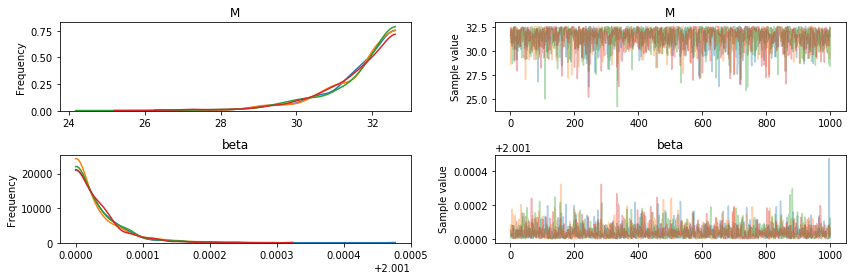

In [4]:
pm.traceplot(trace);

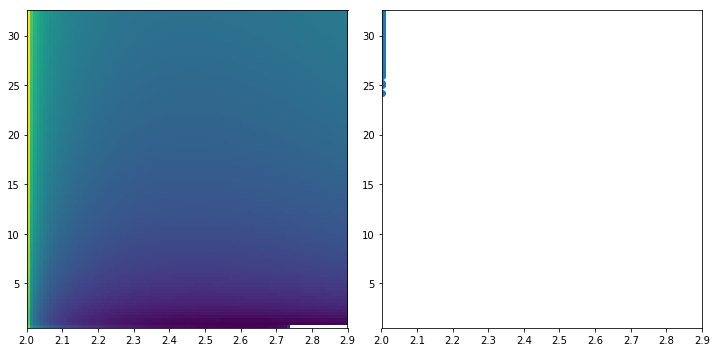

In [5]:
def cust_logp(z):
    M = z[0]
    beta = z[1]
    q = gamma/(beta - 2) - 3/2
    B = (G*M*10**12)/((beta-2)*(R**(3 - beta)))
    K = (gamma - 3)/((rmin**(3 - gamma))*((2*B)**0.5))
    logp = -np.log(K*((1 -(( 1/(2*B) )*((vr**2)*r**(beta - 2))))**(q+1))*(r**(1-gamma +(beta/2))))
    return np.sum(logp)

grid = np.mgrid[32.6:.5:100j, 2.001:2.9:100j]
Z = np.asarray([cust_logp(g) for g in grid.reshape(2, -1).T])
top, left = grid[:, 0, 0]
bottom, right = grid[:, -1, -1]
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(Z.reshape(100,100), extent=[left, right, bottom, top], aspect='auto');

ax[1].scatter(trace['beta'], trace['M'])
ax[1].set_xlim([2.001,2.9])
ax[1].set_ylim([.5,32.6])

plt.tight_layout();

In [6]:
pm.summary(trace)

mean        sd      mc_error    hpd_2.5   hpd_97.5   n_eff  \
M     31.530833  1.032156  1.978438e-02  29.427561  32.599543  2553.0   
beta   2.001037  0.000039  7.922676e-07   2.001000   2.001114  2556.0   

          Rhat  
M     1.000242  
beta  0.999657

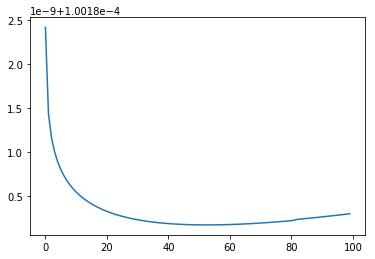

In [7]:
Znorm = np.exp(Z/np.nansum(Z))
Znorm /= np.nansum(Znorm)
plt.plot(np.nanmean(Znorm.reshape(100,100), axis=0));

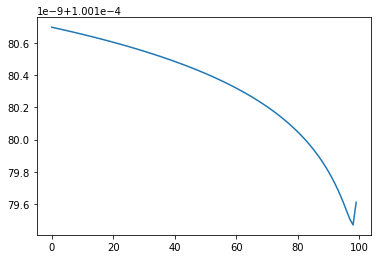

In [8]:
plt.plot(np.nanmean(Znorm.reshape(100,100), axis=1));